# Setup and import data

This script is to be run Monday 9AM when the database is just updated

It used the new database, and the processing output of long.ipynb, whose name is 
of the form (for instance) 'details_0748PM28November2024.pkl'

The output of this notebook is a dataframe with columns:

'pdv': pdvid
'mycup': CUP id
'left_in_stock': How many CUP units are left in stock at the corresponding pdvid
'expected_purchase_mean': How many CUP units the model expects that PDV purchases 'relative_expected_purchase_mean': The same as above, but in units of the pdv mean purchase
'significance': How significant is the estimated purchase
'rate_parameters_to_datapoints': the larger is this number the less likely is to be overfitting. Larger than 1 is quite well enough, although it also works for numbers below 1
'error': Index related to th expected error in the estimation (larger is worse)

In [16]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
import datetime
import multiprocessing as mp
import matplotlib.cm as cm
import time
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [17]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

In [18]:
#mycups = [4007778, 658956, 655741, 660281, 660279, 666120, 4002809, 4027742, 548554, 548518, 4027744, 763027, 4015173, 548552, 548745, 323209, 323212, 548516, 32104, 786527, 4027626, 549271, 32258, 660487, 657662, 660283, 655755, 4015179, 4002648, 629792, 4027799, 4027739, 675928, 325190, 673233, 4027612, 32101, 548517, 4015197, 4027654, 920539, 655747, 4007784, 660201, 919451, 32058, 671126, 4015188, 4027655, 324473, 328008, 324477, 4002652, 4016383, 676351, 655763, 88847, 4027786, 4027740, 766115, 325193, 85948, 4015053, 4027656, 323216, 628724, 326894, 324375, 4027646, 678229, 4027615, 4027593, 628720, 4027806, 660146, 971058, 4015200, 4027769, 32230, 753221, 629091, 4027644, 4027657, 4027714, 4027627, 4027666, 4020724, 655745, 4027578, 4015206, 676354, 12343, 326898, 631278, 4015191, 628726, 4027642, 628722, 659657, 969665, 628730, 4015203, 548955, 4001185, 4020728, 920623, 4027708, 979257, 4027807, 4014266, 4015185, 88861, 4027715, 4027805, 658959, 649401, 4027759, 4027658, 4016379, 666465, 4027779, 920631, 4027663, 631482, 655021, 376008, 757553, 4004756, 674813, 4027696, 9322200, 675123, 4018808, 4027598, 4027768, 649409, 4004776, 753219, 4027638, 662226, 13801, 4015182, 4027709, 677765, 32031, 4027698, 4027752, 4004760, 969300, 88271, 4027737, 4027695, 969673, 4027767, 4018835, 4027699, 678227, 4004762, 969267, 659666, 666122, 4004227, 4027662, 4027738, 675125, 675371, 660205, 969667, 32032, 655753, 4027755, 753217, 4027756, 4027753, 4027635, 4027780, 969229, 4027660, 4027754, 4027803, 4027762, 642911, 969694, 4027763, 4027797, 969297, 971851, 969691, 43518, 4027757, 4027804, 4027795, 763023, 4018850, 374530, 637141, 642627, 4027796, 4004406, 3320, 4019500, 969276, 4027746, 4015194, 4027724, 969306, 969656, 2669, 659655, 4027726, 4004409, 4019419, 4004415, 4027798, 854008, 4027800, 4019417, 4027777, 4016381, 854004, 4019421, 4004412, 971848, 678244, 4027801, 4019503, 969661, 666468, 249462, 4019497, 4027782, 324332, 673203]
topcups = pd.read_excel('data/vendimia/Top Productos.xlsx') 
topcups.sort_values(by='VENTA_NETA', ascending=False, inplace=True)
mycups = list(topcups.iloc[:65]['CUP_SAP_CODE']) # Select the top 65 
mycanals = ['Autoservicio', 'Kiosco Ventana', 'Maxi Kiosco', 'Tradicionales']
cups2names = pd.read_csv('data/vendimia/cups-to-names.csv')
mycups2 = []
for cc in mycups:
    dd = cups2names[cups2names['CUP_SAP_CODE']==cc]['CUPDESCRIPTION']
    mycups2.append([cc,[x for x in list(dd) if isinstance(x,str)]]) # This list contains first element the CUP, second element all the products represented by that CUP

In [19]:
# Import the file that is the output of long.ipynb
# This dataframe contains for each CUP all the detailed information about its relationsship 
# to each one of the PDVs that have purchased it
state = pd.read_pickle('data/vendimia/details_0748PM28November2024.pkl')

In [20]:
state[:5]

,CUP,Description,CANAL,unit/kg,Rhat,datapoints_and_parameters,R_pearson,days_strengths,unfolding-on-PDVs,maxday
0,4007778,[OREO PAQUETE ...,All,0.118,"[1.0, 0.0]","[17531, 1803, 9.723239046034386]",0.482,date weekday day-strengt...,pdv size_mean size_std units_pu...,314
1,658956,[PEPITOS PAQUETE ...,All,0.119,"[1.0, 0.001]","[8526, 1087, 7.84360625574977]",0.494,date weekday day-strengt...,pdv size_mean size_std units_pur...,314
2,655741,"[VARIEDAD 16X450G, VARIEDAD PARAGUAS 16X450G, ...",All,0.390,"[1.0, 0.001]","[5911, 932, 6.342274678111588]",0.634,date weekday day-strengt...,pdv size_mean size_std units_pur...,314
3,660281,"[CH.BELD MENTA FUERTE, CH.BELD MENTA FUERTE, B...",All,0.050,"[1.0, 0.001]","[8245, 1093, 7.543458371454712]",0.425,date weekday day-strengt...,pdv size_mean size_std units_pur...,314
4,660279,"[BELDENT MENTA 20X20 PROMO19 (76222106602100),...",All,0.050,"[1.0, 0.001]","[3834, 687, 5.580786026200873]",0.460,date weekday day-strengt...,pdv size_mean size_std units_pur...,314


In [21]:
state.iloc[0]['days_strengths']

,date,weekday,day-strength
0,2024-07-31 00:00:00,3,0.580858
1,no-in-data,4,0.580304
2,no-in-data,5,0.587895
3,no-in-data,6,0.575407
4,no-in-data,0,0.010084
...,...,...,...
96,2024-11-04 00:00:00,1,0.050557
97,2024-11-05 00:00:00,2,0.863202
98,2024-11-06 00:00:00,3,0.918379
99,2024-11-07 00:00:00,4,0.200654


In [22]:
######################################
#                                    #
#         MODIFY HERE FILENAME       #
#                                    #
#                                    #
######################################
filename = '20241204-rosario-full.csv' # Query for this filename is the same used in long.ipynb.  Just that now it conatins more recent info
dir = 'data/vendimia/'
mydatanew = pd.read_csv(dir+filename)
mydatanew = mydatanew[(mydatanew['ANIO'] == 2024) & (mydatanew['KILOS'] > 0) & (mydatanew['DISTRIBUIDOR'] == 'LA VENDIMIA S.RL.')]

In [23]:
# Uncomment below for testing
#mydatanew = mydatanew[mydatanew['FECHA'] < '2024-11-02']

## Add column with day since 1JAN2024
mydatanew['DIA'] = mydatanew['DIA'].astype(int) 
mydatanew['SEMANA'] = mydatanew['SEMANA'].astype(int) 
mydatanew.loc[:,'day'] = (mydatanew['SEMANA']-1) * 7 + mydatanew['DIA']
mydatanew['day'] = mydatanew['day'].astype(int)
maxdaynew = max(mydatanew['day'])
print(maxdaynew)

335


In [24]:
mydatanew

,PDVID,SKUID,VENTA_NETA,KILOS,LITROS,FECHA,ANIO,SEMANA,DIA,JEFATURA,CANAL,DISTRIBUIDOR,CUP_SAP_CODE,CATEGORIA,SUBCATEGORIA,SEGMENTO,day
0,148395,170295,6569.136,0.33000,0.0,2024-07-12 00:00:00,2024,28,5,ROSARIO,Tradicionales,LA VENDIMIA S.RL.,4027654,Chocolates,Tabletas,Solidos,194
1,148406,177540,2243.560,0.17000,0.0,2024-05-03 00:00:00,2024,18,5,ROSARIO,Tradicionales,LA VENDIMIA S.RL.,766115,Chocolates,Tabletas,Solidos,124
2,148407,180793,6433.530,0.35625,0.0,2024-07-26 00:00:00,2024,30,5,ROSARIO,Kiosco Ventana,LA VENDIMIA S.RL.,324477,Biscuits,Dulces Rellenas,Banada,208
3,148409,180786,3109.240,0.23750,0.0,2024-03-15 00:00:00,2024,11,5,ROSARIO,Tradicionales,LA VENDIMIA S.RL.,324473,Biscuits,Dulces Rellenas,Banada,75
4,148474,180786,18500.000,1.18750,0.0,2024-07-04 00:00:00,2024,27,4,ROSARIO,Maxi Kiosco,LA VENDIMIA S.RL.,324473,Biscuits,Dulces Rellenas,Banada,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101338,213451871,180732,1727.760,0.35700,0.0,2024-02-01 00:00:00,2024,5,4,ROSARIO,Kiosco Ventana,LA VENDIMIA S.RL.,658956,Biscuits,Dulces Secas,Regular,32
2101353,213532383,180732,4803.000,0.71400,NaN,2024-09-20 00:00:00,2024,38,5,ROSARIO,Kiosco Ventana,LA VENDIMIA S.RL.,658956,Biscuits,Dulces Secas,Regular,264
2101355,213537062,180732,753.850,0.11900,0.0,2024-05-18 00:00:00,2024,20,6,ROSARIO,Tradicionales,LA VENDIMIA S.RL.,658956,Biscuits,Dulces Secas,Regular,139
2101356,213576949,180732,530.100,0.11900,0.0,2024-02-28 00:00:00,2024,9,3,ROSARIO,Tradicionales,LA VENDIMIA S.RL.,658956,Biscuits,Dulces Secas,Regular,59


# Process state

In [25]:
out = []
# i runs ove all cups in input file details_xxxx
for i in range(len(state)):
    print(i, len(out))    
    try:    
        mycup = state.iloc[i]['CUP']
        maxday = state.iloc[i]['maxday']
        days_strengths = state.iloc[i]['days_strengths']
            
        # Find mean day-strength in last 4 weeks
        # for each weekday
        n_weeks = 4
        dmean = [[0,0.05,0.05]] # Sunday=0, and set its strength as very small
        for weekday in range(1,7):
            weekday_strength = days_strengths[days_strengths['weekday']==weekday]['day-strength']
            dmean.append([weekday,np.mean(weekday_strength[-n_weeks:]), np.std(weekday_strength[-n_weeks:])])
        dmean = pd.DataFrame(dmean, columns=['DIA','d-strength','d-strength-sigma'])
        
        # loop over PDVs: extract its PDVid, its size, and compute the accumulated consumption during the missing days
        for row in range(len(state.iloc[i]['unfolding-on-PDVs'])):
            pdv = int(state.iloc[i]['unfolding-on-PDVs'].iloc[row]['pdv'])
            size = state.iloc[i]['unfolding-on-PDVs'].iloc[row]['size_mean']
            last_purchase_within_bounds = 1
            
            # Get the last purchase ammount of this pdv in this mycup
            purchase_days = mydatanew[(mydatanew['PDVID']==pdv) & (mydatanew['CUP_SAP_CODE']==mycup)]['day'].values
            purchase_days = np.sort(purchase_days)
            if purchase_days[-1] >= maxday: # If there was a purchase after the maxday on which long.ipynb was run
                last_purchase_day = purchase_days[-2]
                # Then the PDV has increased its stock in the following ammount:
                to_stock = mydatanew[(mydatanew['PDVID']==pdv) & (mydatanew['CUP_SAP_CODE']==mycup) & (mydatanew['day']==purchase_days[-1])]['KILOS'].values[0]
            else:
                last_purchase_day = purchase_days[-1]
                to_stock = 0
            if last_purchase_day < maxday - len(days_strengths):
                # We have a problem, this PDV didn't purchase for very long, we solve it dramatically assigning a ficticious last day purchase within the allowed range            
                last_purchase_within_bounds = 0        
            # Get ammount of last purchase (excluding last week) to get the idea of how much we have to reach to purchase again
            last_purchase = mydatanew[(mydatanew['PDVID']==pdv) & (mydatanew['CUP_SAP_CODE']==mycup) & (mydatanew['day']==last_purchase_day)]['KILOS'].values[0]
            # This is what it would have in stock the PDV
            last_purchase = last_purchase + to_stock 
                    
            # Get now the accumulated estimated sales of this pdv in this mycup        
            accumulated_sales = 0
            # First get the accumulated from days previous to last week
            if last_purchase_day < maxday: # This is to avoid crash if last week there were two purchases
                ## get index in days_strangth corresponding to last purchase
                last_purchase_date = mydatanew[mydatanew['day']==last_purchase_day]['FECHA'].values
                if len(set(last_purchase_date)) == 1:
                    last_purchase_date = last_purchase_date[0]
                    if last_purchase_within_bounds:
                        starting_index = days_strengths[days_strengths['date']==last_purchase_date].index[0]
                    else:
                        starting_index = 0
                else:
                    print('error in', last_purchase_date)    
                ## Add accumulated sales
                for row2 in range(starting_index, len(days_strengths)):
                    accumulated_sales += days_strengths.iloc[row2]['day-strength'] * size        
            # Second get the accumulated during the new week
            for new_days in range(max(maxday, last_purchase_day), maxdaynew+1):        
                new_week_day = mydatanew[mydatanew['day']==new_days]['DIA'].values
                if len(new_week_day) > 0:
                    if len(set(new_week_day)) == 1:
                        new_week_day = new_week_day[0]        
                        accumulated_sales += dmean[dmean['DIA']==new_week_day]['d-strength'].values[0] * size
                    else:
                        print(i, mycup, pdv, 'Error in day:',new_days)
    
            # Add row to output
            ## (Note: units/kg is wrong, actually it should read kg/unit)
            accumulated_sales = accumulated_sales  * state.iloc[i]['unit/kg']
            mean_purchase = state.iloc[i]['unfolding-on-PDVs'][state.iloc[i]['unfolding-on-PDVs']['pdv']==pdv]['units_purchased_mean'].values[0] * state.iloc[i]['unit/kg']
            std_purchase = state.iloc[i]['unfolding-on-PDVs'][state.iloc[i]['unfolding-on-PDVs']['pdv']==pdv]['units_purchased_std'].values[0] * state.iloc[i]['unit/kg']
            error = state.iloc[i]['unfolding-on-PDVs'][state.iloc[i]['unfolding-on-PDVs']['pdv']==pdv]['error'].values[0]
            left_in_stock = last_purchase - accumulated_sales
            expected_purchase_mean = mean_purchase - left_in_stock
            relative_expected_purchase_mean = (mean_purchase - left_in_stock)/mean_purchase
            if std_purchase != 0 :
                significance = expected_purchase_mean / std_purchase
            else:
                #significance = min(5, expected_purchase_mean / state.iloc[i]['unit/kg']) # Let's put the number of units. It is arbitrary, but OK
                significance = np.sign(expected_purchase_mean) * 5
            rate_parameters_to_datapoints = state.iloc[i]['datapoints_and_parameters'][2]
            out.append([pdv, mycup, left_in_stock , expected_purchase_mean, relative_expected_purchase_mean, significance, rate_parameters_to_datapoints, error])
    except:
        print('Error at row =',i)

out = pd.DataFrame(out, columns=['pdv', 'mycup', 'left_in_stock' , 'expected_purchase_mean', 'relative_expected_purchase_mean', 'significance', 'rate_parameters_to_datapoints', 'error'])

0 0
1 1483
2 2250
3 2862
4 3635
5 4002
6 4346
7 4755
8 4980
9 5608
10 6223
11 6267
12 6371
13 6809
14 7403
15 8255
16 8472
17 8727
18 9266
19 9336
20 9917
21 10354
22 10962
23 11102
24 11540
25 11656
26 11735
27 12107
28 12270
29 12380
30 12530
31 12634
32 12753
33 12802
34 12895
35 12927
36 12967
37 13003
38 13503
39 13615
40 13793
41 13856
42 13907
43 13942
44 13955
45 13977
46 14005
47 14414
48 14513
49 14639
50 14684
51 14847
52 14901
53 14944
54 15054
55 15063
56 15280
57 15305
58 15324
59 15427
60 15465
61 15501
62 15526
63 15552
64 15609


In [26]:
out.sort_values(by='significance', ascending=False, inplace=True)
out = out[out['significance'].notna()]
out.reset_index(inplace=True, drop=True)
out

,pdv,mycup,left_in_stock,expected_purchase_mean,relative_expected_purchase_mean,significance,rate_parameters_to_datapoints,error
0,151872,629792,-13.948677,17.098677,5.428151,424.820048,3.238298,0.320776
1,209980329,548516,-4.503336,6.477836,3.280748,392.596150,7.012806,0.570671
2,151872,766115,-11.113564,14.322314,4.463518,254.744743,1.053672,0.354959
3,151912,4027740,-4.943248,9.713860,2.036187,239.405749,2.447867,0.470291
4,151872,4027740,-4.562465,9.345501,1.953885,186.132524,2.447867,0.685113
...,...,...,...,...,...,...,...,...
15136,150260,548517,4.551482,-4.248149,-14.004885,-30.774350,6.826829,0.891897
15137,209981652,548554,2.027662,-1.758862,-6.543385,-32.055907,7.265048,0.479831
15138,209981652,548517,4.735080,-4.480535,-17.602102,-59.935617,6.826829,0.264238
15139,151278,4007778,39.548388,-39.228103,-122.478465,-105.558984,9.723239,2.195821


In [27]:
filename = 'data/vendimia/results_short_days_'+str(maxday)+'-'+str(maxdaynew)+'.pkl'
out.to_pickle(filename)
print(filename)

data/vendimia/results_short_days_314-335.pkl


# Validation

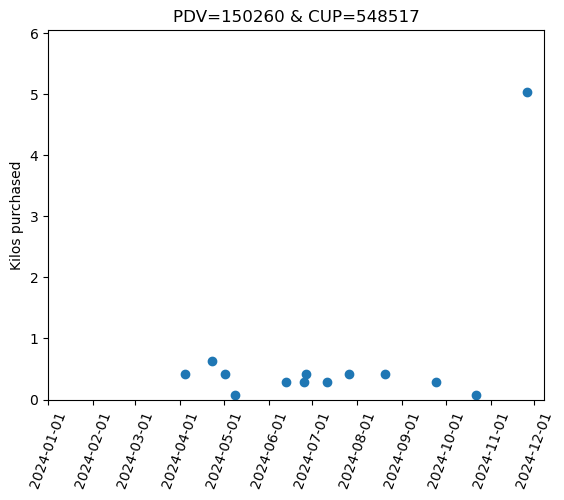

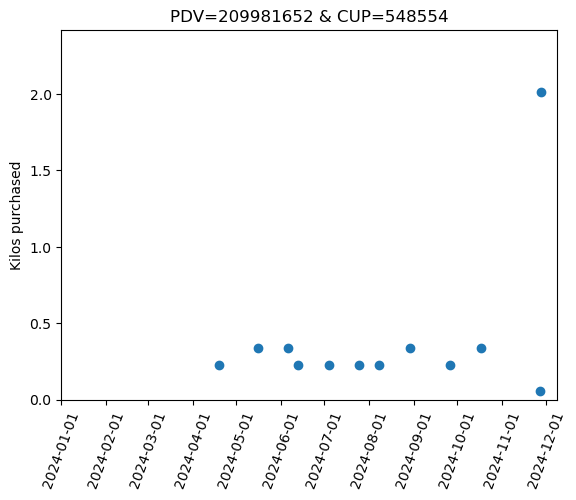

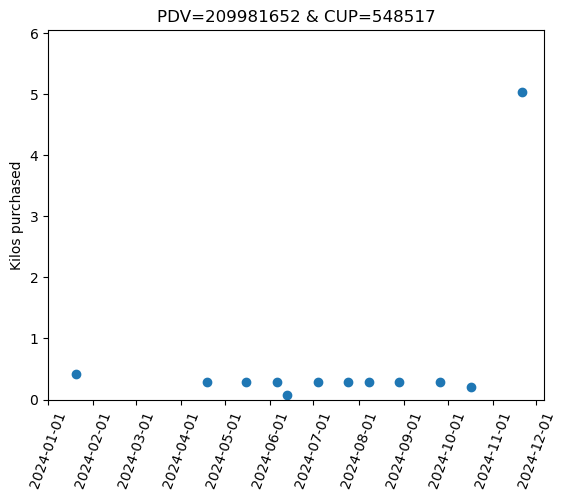

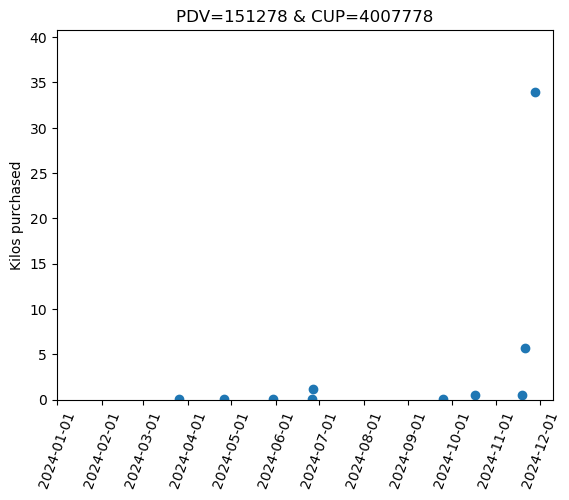

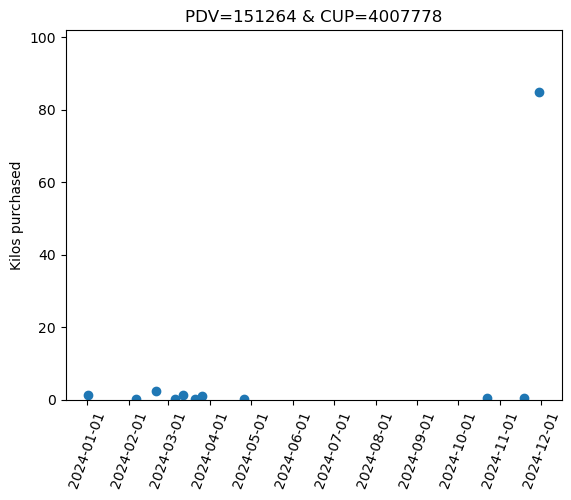

In [29]:
# Verify that the predictions make sense
# Take either the first 5 or the last 5 from the dataframe 'out' and test that
# if it is predicted to buy, then it is because it does not purchase for a while, 
# and if it is predicted to don't buy then it is because it has recently bought a lot

#for i in range(5):
for i in range(len(out)-5, len(out)):    
    pdv = out.iloc[i]['pdv']
    cup = out.iloc[i]['mycup']    
    myframe = mydatanew[(mydatanew['PDVID']==pdv) & (mydatanew['CUP_SAP_CODE']==cup)].sort_values(by='FECHA')
    #display(myframe)
    plt.scatter([datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date() for x in myframe['FECHA']] , myframe['KILOS'])
    plt.ylim(0,max( myframe['KILOS'])*1.2)
    #plt.xlim(myframe['FECHA'].iloc[0], datetime.date(2024, 11, 20))
    #plt.xticks([datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date() for x in myframe['FECHA']] + [datetime.date(2024,11,20)], rotation=70)
    plt.xticks([datetime.date(2024,x,1) for x in range(1,13)], rotation=70)
    plt.ylabel('Kilos purchased')
    plt.title('PDV='+str(int(pdv))+' & CUP='+str(int(cup)))
    plt.show()